Welcome to the "how to" of Markov Chain Monte Carlo using PYMC. A python software package allowing you to run MCMC with ease. In the following case studies we will be applying this to the biological domain.

Case Study 1: Growth Only

First you need to read in the data. Pandas is the defacto package for this task so we'll start there. You will read in the data as seen below and you will grab the values from the columns as shown below.

In [1]:
# Step 1: Load and view data
import pandas as pd
data = pd.read_csv("case_study_1/python/data/phaeocystis_control.csv")
time = data['times'].values
obs = data['cells'].values
#plt.scatter(time, obs)

Now, here is the first thing we need to do. Wetup the ODE that we are going to have try to adapt to the data. In this first example we are going to setup a logistic ODE. We will do a little hand waving over some things that PYMC does behind the scenes but that is okay! We will cover everything you truly need to understand to make proper use of the software. 

$$
\frac{dy}{dt} = \mu y
$$

$$
y(t) = y_0 e^{\mu t}
$$

The ODE above contains $\mu$ (mum), a growth rate which is set ahead of time by 'params'. y[0] is the current state value for the interation the markov chain is on. The function returned is expected to be in the form of a list, or list of lists. This will become even more clear later, so for now just trust :)

In [2]:
# This is how you declare a function in python. Python is incredibly flexible.
def ode(y, t, params):
    mum = params[0]
    return [mum * y[0]]

This is our first use of pymc. This is the creation of the model itself. It takes into account the function, time points, states, theta (amount of 'tunable' parameters), and t0 which is the time step to start at it should always be 0.

(in our case this is 1, this will increase with the amount of states we are tracking, this too will become more clear in the future, so again just trust! ) 

In [3]:
import pymc as pm
cell_model = pm.ode.DifferentialEquation(
    func=ode,
    times=data['times'].values,
    n_states=1,
    n_theta=1,
    t0=0
)

c:\Users\Whisk\miniconda3\envs\MCMC_modeling\Lib\site-packages\pytensor\link\c\cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(


Here we are going to include our additional parameters necessary for the model to run. We are including numpy to assist in our model insertion. 

In [4]:
import numpy as np
with pm.Model() as model:
    mum = pm.TruncatedNormal('mum', mu=0.5, sigma=0.3, lower=0.0, upper=1.0)
    N0 = pm.Lognormal('N0', mu=np.log(obs[0]), sigma=0.1)
    sigma = pm.HalfNormal("sigma", 1)

    y_hat = cell_model(y0=[N0], theta=[mum])
    pm.Normal("Y_obs", mu=pm.math.log(y_hat[:, 0]), sigma=sigma, observed=np.log(obs))

In [5]:
with model:
    trace = pm.sample(draws=1000, tune=1000, chains=4, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mum, N0, sigma]


c:\Users\Whisk\miniconda3\envs\MCMC_modeling\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


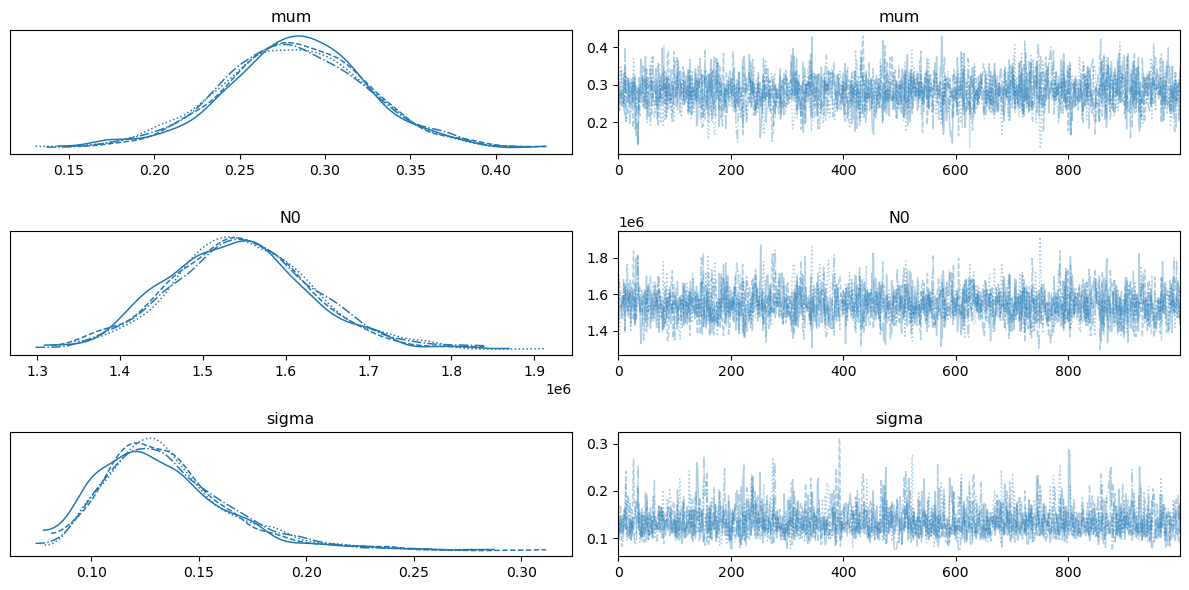

In [6]:
import arviz as az
import matplotlib.pyplot as plt
az.plot_trace(trace)
# az.plot_trace(data, combined=True).axes[0,0].get_yaxis().set_visible(True)  # force y axis
plt.tight_layout()
plt.show()

In [7]:
az.to_netcdf(trace, "tmp_cs1.nc")

'tmp_cs1.nc'

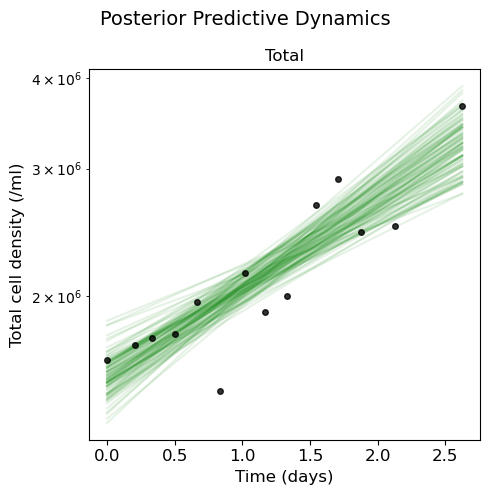

In [ ]:
from utils import plot_trace, plot_convergence, plot_posterior_pairs, posterior_dynamics  # because __init__.py already re-exports it
if False:
    plot_trace(
    trace=trace,
    model=model,
    var_names_map={'N0':'Initial density/ml','mum': 'Growth Rate μ', 'sigma': 'Std Dev σ'},
    var_order=['mum','N0','sigma'],
    fontname='Arial',
    fontsize=12,
    num_prior_samples=2000,
    save_path='case_study_1/python/figures/normal_growth_chains.png'
    )
dataset_postprocessing = {
"Cells": [
        {"time": time, "values": obs},  # replicate 1
    ]
}
def ode_solution2data(solution):
    """
    User-defined function to extract and compute useful outputs from the ODE solution.
    
    Args:
        solution (np.ndarray): shape (time_points, num_variables)

    Returns:
        dict: keys are output variable names, values are 1D arrays over time
    """
    
    total = solution[:, 0]  # Assuming the first column is the total cell count
    return {
        "total": total
    }
if False:
    posterior_dynamics(
    dataset=dataset_postprocessing,
    trace=trace,
    model=model,
    n_plots=100,
    burn_in=50,
    num_variables=1,
    ode_fn=ode,
    ode2data_fn=ode_solution2data,
    save_path="case_study_1/python/figures/vardi_logistic_growth_dynamics.png",
    # the key of this dict is the variable name in the dataset_postprocessing
    var_properties={
        "Cells": {"label": "Total", "color": "black", "ylabel": "Total cell density (/ml)", "xlabel":"Time (days)","sol_key": "total","log": True}
    },
    suptitle="Posterior Predictive Dynamics",
    color_lines='green'
    )

Case Study 1: Growth and Death

$$
\frac{dy}{dt} = (\mu - \delta)\, y
$$

$$
y(t) = y_0 e^{(\mu - \delta)t}
$$


In [8]:
def ode(y, t, params):
    mum,delta = params[0],params[1]
    return [(mum-delta) * y[0]]

In [9]:
import pymc as pm
cell_model = pm.ode.DifferentialEquation(
    func=ode,
    times=data['times'].values,
    n_states=1,
    n_theta=2,
    t0=0
)

In [10]:
import numpy as np
with pm.Model() as model:
    mum = pm.TruncatedNormal('mum', mu=0.5, sigma=0.3, lower=0.0, upper=1.0)
    delta = pm.TruncatedNormal('delta', mu=0.5, sigma=0.3, lower=0.0, upper=1.0)
    N0 = pm.Lognormal('N0', mu=np.log(obs[0]), sigma=0.1)
    sigma = pm.HalfNormal("sigma", 1)

    y_hat = cell_model(y0=[N0], theta=[mum, delta])
    pm.Normal("Y_obs", mu=pm.math.log(y_hat[:, 0]), sigma=sigma, observed=np.log(obs))

In [18]:
with model:
    trace = pm.sample(draws=1000, tune=1000, chains=4, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mum, delta, N0, sigma]


c:\Users\Whisk\miniconda3\envs\MCMC_modeling\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 155 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


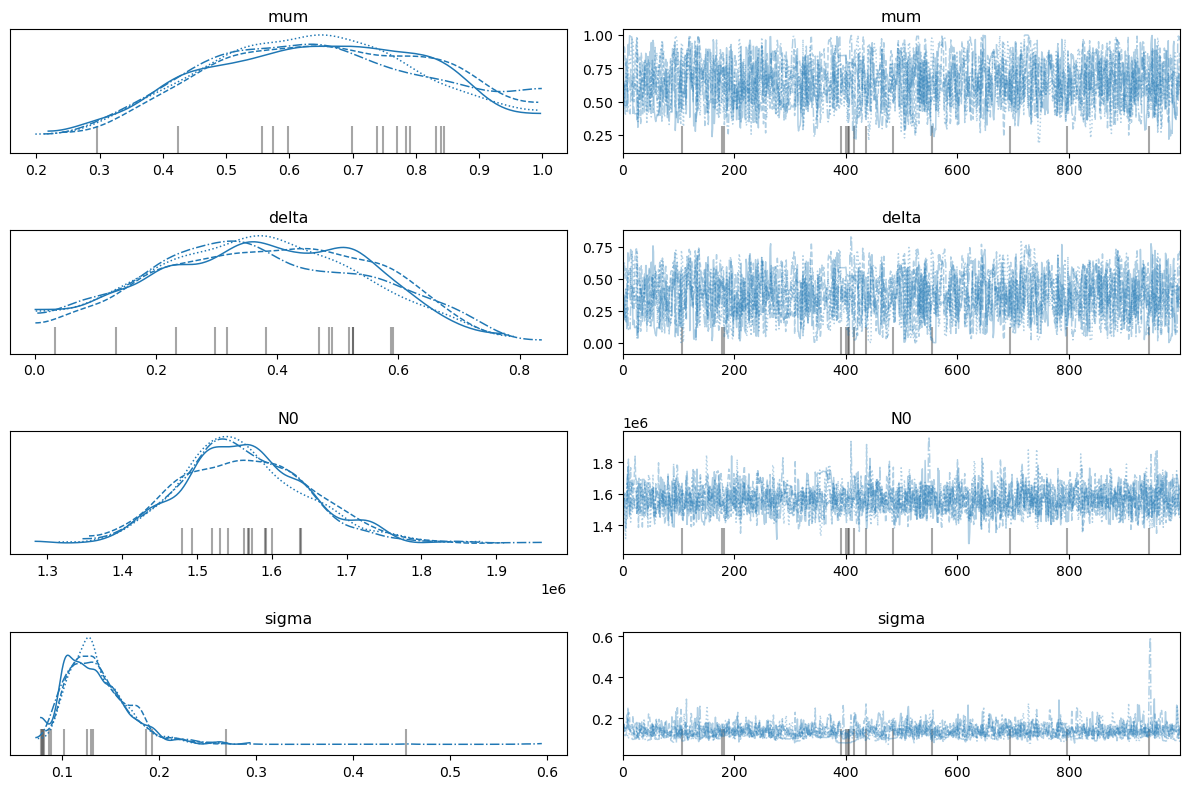

In [22]:
import arviz as az
import matplotlib.pyplot as plt

az.plot_trace(trace)
plt.tight_layout()
plt.show()

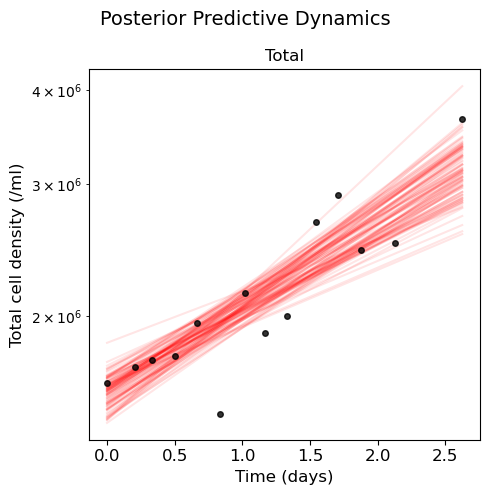

In [ ]:
from utils import plot_trace, plot_convergence, plot_posterior_pairs, posterior_dynamics  # because __init__.py already re-exports it
if True:
    plot_trace(
    trace=trace,
    model=model,
    var_names_map={'N0':'Initial density/ml','mum': 'Growth Rate μ', 'sigma': 'Std Dev σ'},
    var_order=['mum','N0','sigma'],
    fontname='Arial',
    fontsize=12,
    num_prior_samples=2000,
    save_path='case_study_1/python/figures/normal_growthdeath_chains.png'
    )
dataset_postprocessing = {
"Cells": [
        {"time": time, "values": obs},  # replicate 1
    ]
}
def ode_solution2data(solution):
    """
    User-defined function to extract and compute useful outputs from the ODE solution.
    
    Args:
        solution (np.ndarray): shape (time_points, num_variables)

    Returns:
        dict: keys are output variable names, values are 1D arrays over time
    """
    
    total = solution[:, 0]  # Assuming the first column is the total cell count
    return {
        "total": total
    }
if False:
    posterior_dynamics(
    dataset=dataset_postprocessing,
    trace=trace,
    model=model,
    n_plots=100,
    burn_in=50,
    num_variables=1,
    ode_fn=ode,
    ode2data_fn=ode_solution2data,
    save_path="case_study_1/python/figures/vardi_logistic_growthdeath_dynamics.png",
    # the key of this dict is the variable name in the dataset_postprocessing
    var_properties={
        "Cells": {"label": "Total", "color": "black", "ylabel": "Total cell density (/ml)", "xlabel":"Time (days)","sol_key": "total","log": True}
    },
    suptitle="Posterior Predictive Dynamics",
    color_lines='red'
    )